##### 백엔드 코드

In [1]:
import pandas as pd

# 데이터 불러오기 
data = pd.read_csv('raw_data/hospital-inpatient-discharges-sparcs-de-identified-2010-1.csv')
data.head(10)
print(data.shape)

/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_93973/4287711130.py:4: DtypeWarning: Columns (1,2,7,11,29) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('raw_data/hospital-inpatient-discharges-sparcs-de-identified-2010-1.csv')


(2622133, 38)


In [2]:
### 데이터 파악

# 데이터 타입이 mixed 인 컬럼 : [1, 2, 7, 11, 29] 번 째 컬럼
columns = data.columns # 전체 컬럼
for column in columns:
    print(data[column].apply(type).value_counts())

# mixed 데이터 명명 
mixed_columns_index = [1, 2, 7, 11, 29]
mixed_columns_name = data.columns[mixed_columns_index]

# Major 데이터 타입 확인
for column in mixed_columns_name:
    print(data[column].apply(type).unique())
    print(data[column].apply(type).value_counts())

# Minor 데이터 정체 확인 
## 1, 'Health Service Area', 'Hospital County', 'Patient Disposition' -> 결측치 처리 필요
## 2. 'Zip Code - 3 digits' -> 환자 거주지역을 나타내는 의미없는 데이터 -> Drop 
for column in mixed_columns_name:
    not_str_index = data[column].apply(lambda x: type(x) == str)
    print(data[column][~not_str_index].value_counts(dropna=False))


index
<class 'int'>    2622133
Name: count, dtype: int64
Health Service Area
<class 'str'>      2617246
<class 'float'>       4887
Name: count, dtype: int64
Hospital County
<class 'str'>      2617246
<class 'float'>       4887
Name: count, dtype: int64
Operating Certificate Number
<class 'float'>    2622133
Name: count, dtype: int64
Facility ID
<class 'float'>    2622133
Name: count, dtype: int64
Facility Name
<class 'str'>    2622133
Name: count, dtype: int64
Age Group
<class 'str'>    2622133
Name: count, dtype: int64
Zip Code - 3 digits
<class 'str'>      2061890
<class 'int'>       524288
<class 'float'>      35955
Name: count, dtype: int64
Gender
<class 'str'>    2622133
Name: count, dtype: int64
Race
<class 'str'>    2622133
Name: count, dtype: int64
Ethnicity
<class 'str'>    2622133
Name: count, dtype: int64
Length of Stay
<class 'str'>    2523136
<class 'int'>      98997
Name: count, dtype: int64
Type of Admission
<class 'str'>    2622133
Name: count, dtype: int64
Patient Disp

In [3]:
##########################################
# 데이터 전처리 - 결측치 및 비정상적인 값 처리
##########################################

pd.set_option('display.max_columns', None)

# 'Length of Stay' 컬럼 처리
## 문자열 등 비정상적인 값은 NaN으로 변환
data['Length of Stay'] = pd.to_numeric(data['Length of Stay'], errors='coerce')
## NaN이 된 행은 제거
df = data.dropna(subset=['Length of Stay'])
## float → int 로 형변환 (NaN 제거되었으므로 안전)
df['Length of Stay'] = df['Length of Stay'].astype(int)

# NaN 개수가 너무 많은 컬럼 제거
## Source of Payment 2, Source of Payment 3, Operating Provider License Number, Other Provider License Number 컬럼
nan_columns = df.columns[df.isna().sum() > 10_000]
df = df.drop(columns=nan_columns)

# 의미없는 컬럼 제거 
# 'Zip Code - 3 digits'(우편번호) / 'index'(인덱스)
# 'Attending Provider License Number'(주치의 면허번호) / 'Operating Certificate Number'(운영 인증 번호)
df = df.drop(columns=['Zip Code - 3 digits', 'index', 'Attending Provider License Number', 'Operating Certificate Number'])


# Weight(몸무게) 값이 0이 과도하게 많아 의미 없는 컬럼 제거
# 'Birth Weight' 컬럼 삭제
df = df.drop(columns=['Birth Weight'])

/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_93973/480995945.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Length of Stay'] = df['Length of Stay'].astype(int)


In [4]:
### 데이터 전처리 - 이상치 처리 
from utils.cate_outlier import preview_rare_categories, replace_rare_categories
from utils.num_outlier import plot_zscore_outliers_all, remove_zscore_outliers_all
import pandas as pd

num_columns = ['Total Charges', 'Total Costs', 'Length of Stay']
cate_columns = [col for col in df.columns
                if col not in num_columns + ['Patient Disposition']] # target = 'Patient Disposition'

## 범주형 이상치 확인
preview_rare_categories(df, columns=cate_columns, threshold=0.01)

'Health Service Area' 컬럼에는 희귀 범주 없음
'Hospital County' 컬럼에서 희귀 범주 발견 (40개): ['Schenectady', 'Niagara', 'Chemung', 'Warren', 'Rensselaer', 'Otsego', 'Ulster', 'St Lawrence', 'Chautauqua', 'Ontario', 'Jefferson', 'Clinton', 'Saratoga', 'Steuben', 'Putnam', 'Cattaraugus', 'Montgomery', 'Oswego', 'Tompkins', 'Franklin', 'Columbia', 'Sullivan', 'Cayuga', 'Madison', 'Genesee', 'Cortland', 'Wayne', 'Fulton', 'Wyoming', 'Livingston', 'Orleans', 'Allegany', 'Chenango', 'Lewis', 'Delaware', 'Schuyler', 'Herkimer', 'Yates', 'Essex', 'Schoharie']
'Facility ID' 컬럼에서 희귀 범주 발견 (200개): [5.0, 1172.0, 1301.0, 1453.0, 630.0, 1139.0, 1178.0, 636.0, 527.0, 528.0, 181.0, 1176.0, 1165.0, 213.0, 635.0, 1469.0, 3067.0, 1286.0, 924.0, 1318.0, 1628.0, 409.0, 599.0, 1638.0, 1294.0, 207.0, 913.0, 563.0, 1320.0, 1288.0, 1005.0, 1633.0, 1302.0, 1168.0, 1738.0, 1692.0, 471.0, 779.0, 1045.0, 885.0, 776.0, 829.0, 686.0, 943.0, 218.0, 208.0, 1454.0, 3975.0, 3376.0, 552.0, 210.0, 58.0, 1447.0, 1122.0, 1097.0, 598.0, 1445.

'Total Charges' 컬럼 이상치 수 (|Z| > 2): 75301개
'Total Costs' 컬럼 이상치 수 (|Z| > 2): 65946개
'Length of Stay' 컬럼 이상치 수 (|Z| > 2): 94499개


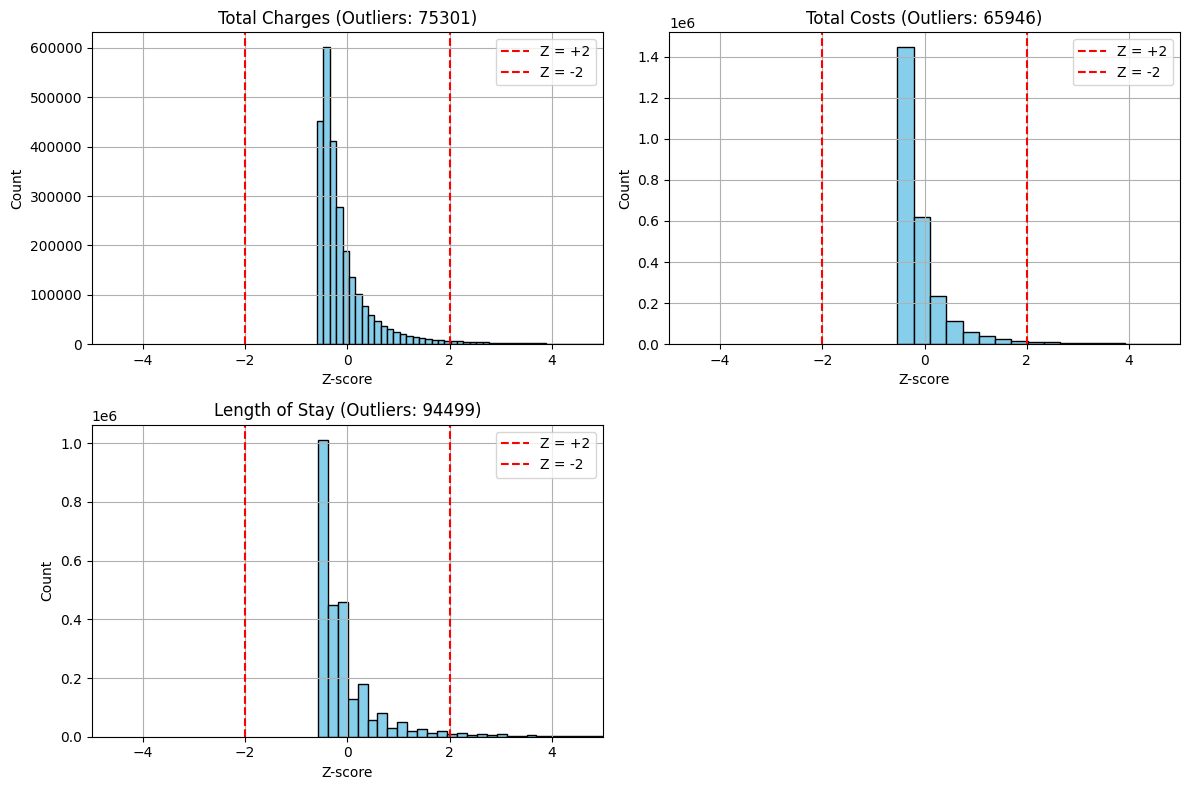

In [5]:
## 1) 수치형 이상치 시각화
bins = [1000, 1000, 80]
plot_zscore_outliers_all(df, columns=num_columns, bins_list=bins, z_thresh=2)

In [6]:
# 이상치 대체 및 삭제

# 1단계: 범주형 컬럼의 희귀값을 'Others'로 대체
df_replaced = replace_rare_categories(df, columns=cate_columns, threshold=0.001)

# 2단계: 수치형 컬럼의 Z-score 이상치를 제거
df_cleaned = remove_zscore_outliers_all(df_replaced, columns=num_columns, z_thresh=2)

df_cleaned.shape

(2481639, 29)

In [7]:
df = df_cleaned

In [10]:
### 모델 선정 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import numpy as np

# -------------------------------
# 대략적인 모델별 성능 비교
# -------------------------------

# -------------------------------
# 공통 전처리 파이프라인 구성
# -------------------------------
# 범주형 데이터 전처리 - Tree based 모델(DecisionTree, RandomForest, XGBoost 등) + Support Vector 모델 
cat_pipeline = make_pipeline( 
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
)
# 범주형 데이터 전처리 - 비 Tree based 모델(LogisticRegression 등)
cat2_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)
# 연속형 데이터 전처리
num_pipeline = make_pipeline(
    KNNImputer(n_neighbors=5),
    StandardScaler()
)
# 파이프라인 - Tree based 모델(DecisionTree, RandomForest, XGBoost 등) + Support Vector 모델 
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cate_columns),
    ('num', num_pipeline, num_columns)
])
# 파이프라인 - 비 Tree based 모델(LogisticRegression 등)
preprocessor2 = ColumnTransformer([
    ('cat', cat2_pipeline, cate_columns),
    ('num', num_pipeline, num_columns)
])
# PCA - SVC 모델에만 적용
pca = PCA(n_components=3)
# SMOTE - 오버 샘플링 기법
smote = SMOTE(k_neighbors=4, sampling_strategy=0.1, random_state=42)
# -------------------------------
# 데이터 분할
# -------------------------------

# 이진 분류 문제로 변환 
X = df.drop(columns=['Patient Disposition'])
y = np.where(df['Patient Disposition'].values == 'Left Against Medical Advice', 1, 0)

# 데이터 셋 분할 - 훈련 데이터 1%, 테스트 데이터 0.2%
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.01, test_size=0.002, random_state=42, stratify=y)


# -------------------------------
# 사용할 회귀 모델 정의
# -------------------------------
models = {
    'LogisticRegression' : LogisticRegression(),
    'KNNNeighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
    # 'Support Vector Classifier': SVC(probability=True)
}

# -------------------------------
# 모델 학습 및 성능 비교
# -------------------------------
results = []
print("="*20, "이진 분류 모델 성능 비교", "="*20)
for name, model in models.items():

    # 레이블 인코딩을 사용하는 모델
    if name in ['KNNNeighbors', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost']:
        pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('model', model)
        ])
    # SVC 모델 - PCA 적용
    elif name == 'Support Vector Classifier':
        pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('pca', pca),
        ('model', model)
        ])
    # LogisticRegression 모델 - OneHotEncoding 적용
    else:
        pipeline = Pipeline([
        ('preprocessor', preprocessor2),
        ('smote', smote),
        ('model', model)
        ])

    # 모델 학습
    pipeline.fit(X_train, y_train)
    # 모델 예측
    y_pred_proba = pipeline.predict_proba(X_test)
    # Threshold : 0.5
    y_pred = np.where(y_pred_proba[:, 1] > 0.5, 1, 0)

    # 평가지표 계산
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # 결과 저장
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    print(f"[{name}] Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

==================== 이진 분류 모델 성능 비교 ====================
[LogisticRegression] Accuracy: 0.9710, Precision: 0.3824, Recall: 0.4643, F1 Score: 0.4194
[KNNNeighbors] Accuracy: 0.9531, Precision: 0.1990, Recall: 0.3571, F1 Score: 0.2556
[Decision Tree] Accuracy: 0.9676, Precision: 0.3212, Recall: 0.3929, F1 Score: 0.3534
[Random Forest] Accuracy: 0.9841, Precision: 0.9459, Recall: 0.3125, F1 Score: 0.4698
[Gradient Boosting] Accuracy: 0.9845, Precision: 1.0000, Recall: 0.3125, F1 Score: 0.4762
[XGBoost] Accuracy: 0.9833, Precision: 0.8222, Recall: 0.3304, F1 Score: 0.4713


In [12]:
print(df['Type of Admission'].value_counts(dropna=False))


# 이탈 여부 컬럼 생성 (1 = 이탈, 0 = 정상퇴원)
df['y'] = np.where(df['Patient Disposition'] == 'Left Against Medical Advice', 1, 0)


Type of Admission
Emergency        1538771
Elective          486663
Newborn           235349
Urgent            216399
Not Available       3665
Others               792
Name: count, dtype: int64


In [13]:
# 각 Type of Admission별 이탈률 계산
admission_evasion = df.groupby('Type of Admission')['y'].mean().sort_values(ascending=False)

print(admission_evasion)


Type of Admission
Others           0.031566
Emergency        0.030216
Elective         0.014406
Urgent           0.011899
Not Available    0.008731
Newborn          0.000153
Name: y, dtype: float64


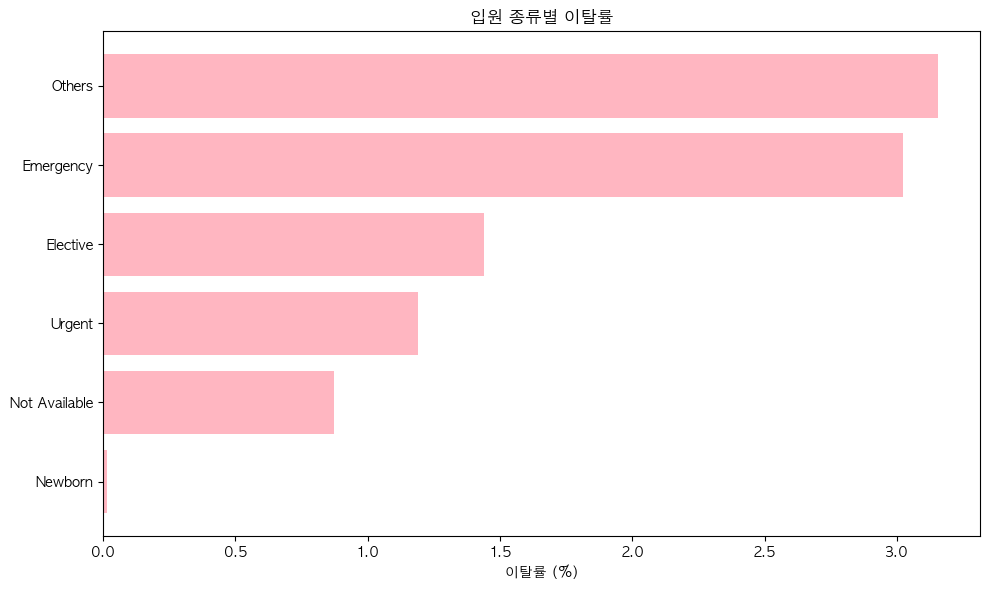

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bars = plt.barh(admission_evasion.index, admission_evasion.values * 100, color='Lightpink')
plt.xlabel('이탈률 (%)')
plt.title('입원 종류별 이탈률')
plt.gca().invert_yaxis()

# 막대에 수치 표시
# for bar in bars:
#     plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
#              f'{bar.get_width():.1f}%', va='center')

plt.tight_layout()
plt.show()


전체 이탈률이 낮은 이유
본 데이터셋은 총 240만 건 이상의 입원 기록 중, 자가 퇴원(LAMA) 사례는 약 56,000건으로 약 2.3% 수준입니다.

병원에서의 자의 퇴원은 대부분 예외적인 상황이며, 특히 중증도 높고 응급도가 높은 경우에는 환자가 의료진의 권고 없이 이탈하기 어렵기 때문입니다.

📢 "전체적으로 이탈률이 낮은 것은 의료 기관의 조기 개입, 보호자 동의, 응급실 및 중환자관리 체계 등 복합적인 요인이 작용한 결과로 볼 수 있습니다."



🔍 입원유형별 자의 퇴원 이탈률 분석
분석 결과, 전체 평균 이탈률은 약 2.3%로 낮은 편이며, 입원 유형별로는 Others, Emergency 입원 유형에서 자의 퇴원 비율이 높게 나타났습니다.
특히 Others 유형의 경우, 표준 코드화되지 않은 입원경로(외부 전원, 보호자 요청 등)가 포함돼 병원 관리의 사각지대일 수 있으며, 이탈 가능성이 비교적 높습니다.
반면 Newborn 유형은 신생아 입원이므로 자의 퇴원이 사실상 불가능하다는 점에서 가장 낮은 이탈률을 보였습니다.

| 입원유형          | 이탈률 (%)  | 해석 요약                                                             |
| ------------- | -------- | ----------------------------------------------------------------- |
| Others        | **3.16** | 코드화되지 않은 입원 유형, 외부에서 전원된 환자 등이 포함되어 **관리 사각지대에 있을 가능성**           |
| Emergency     | 3.02     | 응급 상황에서 입원한 환자 중 **만족스럽지 못한 응급 대응** 또는 **의료진과의 갈등** 등으로 인해 이탈 가능성 |
| Elective      | 1.44     | 선택적 입원으로 치료에 대한 계획성이 높고 **자가 퇴원 가능성 낮음**                          |
| Urgent        | 1.19     | 준응급 상황으로 일부 불만족 환자 존재 가능성                                         |
| Not Available | 0.87     | 데이터 누락, 비정상 수집 등의 가능성                                             |
| Newborn       | **0.01** | 신생아의 경우 보호자 책임 하에 입퇴원이 결정되므로 **자의 퇴원 사실상 불가능**                    |


In [14]:
# 이상치 제거된 데이터프레임 기준
print("💰 Total Charges:")
print(df_cleaned['Total Charges'].describe())

print("\n💸 Total Costs:")
print(df_cleaned['Total Costs'].describe())


💰 Total Charges:
count    2.481639e+06
mean     2.165156e+04
std      2.082174e+04
min      1.000000e-02
25%      7.571945e+03
50%      1.463323e+04
75%      2.799064e+04
max      1.265599e+05
Name: Total Charges, dtype: float64

💸 Total Costs:
count    2.481639e+06
mean     8.413465e+03
std      7.929400e+03
min      0.000000e+00
25%      3.157285e+03
50%      5.801610e+03
75%      1.076115e+04
max      5.534683e+04
Name: Total Costs, dtype: float64


In [15]:
# 이탈 환자와 비이탈 환자의 비용 분포 비교
print("이탈 환자의 Total Charges")
print(df_cleaned[df_cleaned['y'] == 1]['Total Charges'].describe())

print("\n비이탈 환자의 Total Charges")
print(df_cleaned[df_cleaned['y'] == 0]['Total Charges'].describe())



이탈 환자의 Total Charges
count     56174.000000
mean      11594.626344
std       12401.862029
min         340.000000
25%        4571.895000
50%        7641.650000
75%       13425.575000
max      125400.000000
Name: Total Charges, dtype: float64

비이탈 환자의 Total Charges
count    2.425465e+06
mean     2.188448e+04
std      2.091954e+04
min      1.000000e-02
25%      7.709640e+03
50%      1.486208e+04
75%      2.833406e+04
max      1.265599e+05
Name: Total Charges, dtype: float64


In [16]:
print("\n이탈 환자의 Total Costs")
print(df_cleaned[df_cleaned['y'] == 1]['Total Costs'].describe())

print("\n비이탈 환자의 Total Costs")
print(df_cleaned[df_cleaned['y'] == 0]['Total Costs'].describe())


이탈 환자의 Total Costs
count    56174.000000
mean      4786.135567
std       5426.997199
min        147.520000
25%       1881.780000
50%       3044.725000
75%       5333.177500
max      55216.520000
Name: Total Costs, dtype: float64

비이탈 환자의 Total Costs
count    2.425465e+06
mean     8.497474e+03
std      7.958498e+03
min      0.000000e+00
25%      3.218590e+03
50%      5.883150e+03
75%      1.088074e+04
max      5.534683e+04
Name: Total Costs, dtype: float64


In [17]:
import pandas as pd

# 1. 사전 세팅 (이탈 여부 라벨링이 되어 있다고 가정)
# df['y'] = np.where(df['Patient Disposition'] == 'Left Against Medical Advice', 1, 0)

# 2. 사용할 컬럼
columns = ['Total Costs', 'Total Charges']
bin_count = 6  # 원하는 구간 수

# 3. 결과 저장용 딕셔너리
evasion_by_price_bin = {}

# 4. 각 컬럼별 구간 나누고 이탈률 계산
for col in columns:
    # 구간 생성: 분위수 기준으로 나눔
    df[f'{col}_bin'] = pd.qcut(df[col], q=bin_count, duplicates='drop')

    # 이탈률 계산
    evasion_rate = df.groupby(f'{col}_bin')['y'].mean() * 100  # 백분율로
    evasion_by_price_bin[col] = evasion_rate

    # 결과 출력
    print(f"\n💵 [{col}] 가격 구간별 이탈률 (%)")
    print(evasion_rate.round(2))


/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_93973/2812369076.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  evasion_rate = df.groupby(f'{col}_bin')['y'].mean() * 100  # 백분율로



💵 [Total Costs] 가격 구간별 이탈률 (%)
Total Costs_bin
(-0.001, 2381.613]       5.03
(2381.613, 3953.18]      3.61
(3953.18, 5801.61]       1.89
(5801.61, 8557.54]       1.32
(8557.54, 14122.347]     0.99
(14122.347, 55346.83]    0.74
Name: y, dtype: float64

💵 [Total Charges] 가격 구간별 이탈률 (%)
Total Charges_bin
(0.009000000000000001, 5737.667]    4.87
(5737.667, 9582.8]                  3.49
(9582.8, 14633.23]                  2.21
(14633.23, 22218.903]               1.45
(22218.903, 37000.933]              0.97
(37000.933, 126559.9]               0.59
Name: y, dtype: float64


/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_93973/2812369076.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  evasion_rate = df.groupby(f'{col}_bin')['y'].mean() * 100  # 백분율로


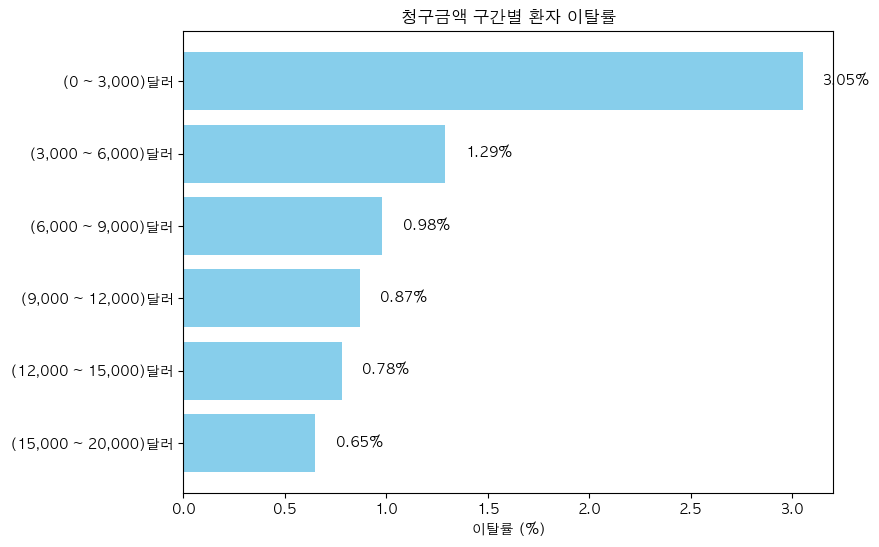

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

# macOS에서 한글 폰트 설정
mpl.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

def plot_evasion_rate_by_range(ranges, rates, title):
    # 데이터프레임 구성 및 이탈률 기준 정렬
    df = pd.DataFrame({'구간': ranges, '이탈률': rates})
    df = df.sort_values(by='이탈률', ascending=False)

    # 그래프 그리기
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(df['구간'], df['이탈률'], color='skyblue')
    ax.set_xlabel('이탈률 (%)')
    ax.set_title(title)
    ax.invert_yaxis()

    # 값 표시
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.1, bar.get_y() + bar.get_height()/2,
                f'{width:.2f}%', va='center')

    # 레이아웃 조정 및 표시
    plt.subplots_adjust(left=0.3, right=0.95)
    plt.show()

# 예시 호출
ranges = ["(0 ~ 3,000)달러", "(3,000 ~ 6,000)달러", "(6,000 ~ 9,000)달러",
          "(9,000 ~ 12,000)달러", "(12,000 ~ 15,000)달러", "(15,000 ~ 20,000)달러"]
rates = [3.05, 1.29, 0.98, 0.87, 0.78, 0.65]

plot_evasion_rate_by_range(ranges, rates, "청구금액 구간별 환자 이탈률")


당신의 데이터는 병원 전체 퇴원 기록 중 극히 일부만이 "자의로 의료진 권고를 무시하고 퇴원한" 사례입니다. 이건 일반적인 병원 진료 데이터에서 흔한 현상입니다.

예를 들어:

구분	수치 (예시)
전체 입원 환자 수	약 200만 명
이탈 환자 수	약 5~6만 명
전체 이탈률 (평균)	약 2.5~3% 정도

→ 따라서 어떤 가격 구간에서든, 평균적으로 이탈률이 1~5% 사이로 나오는 건 데이터 특성상 매우 자연스러운 결과입니다.



그럼에도 불구하고 의미가 있습니다.


➡ 총 청구 금액이 낮을수록 이탈률이 높고, 금액이 커질수록 이탈률이 낮아지는 경향이 뚜렷합니다.

해석: 왜 저렴한 금액에서 이탈률이 높을까?
응급 환자 또는 단기 입원 환자가 많을수록 총 비용이 낮고,

이들 중 일부는 충분한 설명 없이 퇴원하거나 치료를 중단할 가능성이 큽니다.

반대로 고비용 치료를 받는 환자는 상태가 더 심각하거나 입원 결정이 더 신중했을 확률이 높습니다 → 이탈 가능성 낮음


전체 이탈률 자체가 2~3%로 낮기 때문에, 각 구간의 이탈률도 당연히 낮습니다.

하지만 이탈률의 상대적인 차이는 분명합니다.

**"이탈 환자 = 병원이 수익을 놓친 환자"**라고 본다면, 병원은 낮은 비용 구간 환자들에 대해 더 많은 설명, 만족도 관리, 응급실 이탈 방지 조치가 필요합니다.

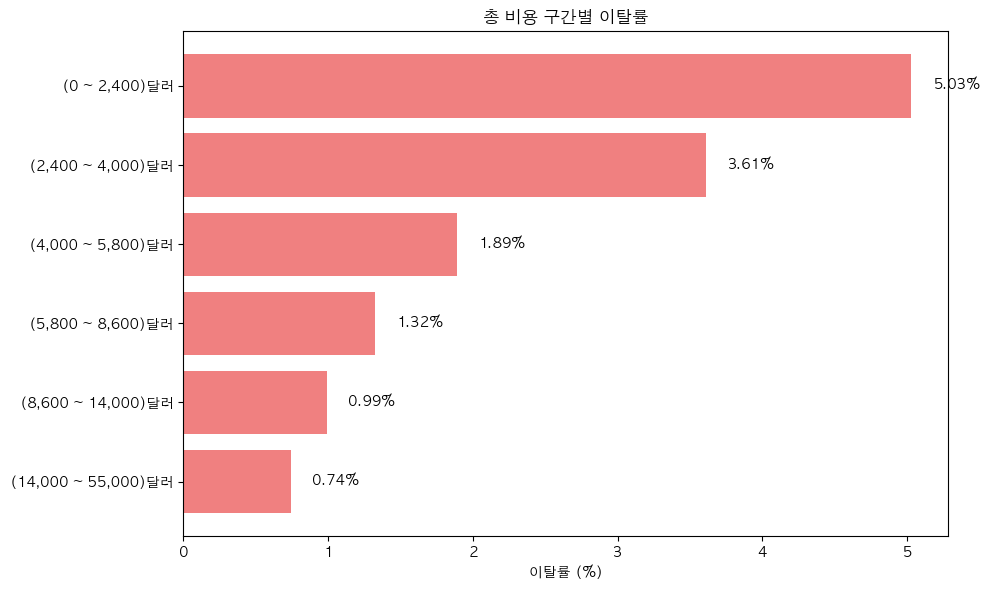

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# macOS 한글 폰트 설정
mpl.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# Total Costs 구간별 이탈률 데이터
evasion_rate_cost = pd.Series({
    '(0 ~ 2,400)달러': 5.03,
    '(2,400 ~ 4,000)달러': 3.61,
    '(4,000 ~ 5,800)달러': 1.89,
    '(5,800 ~ 8,600)달러': 1.32,
    '(8,600 ~ 14,000)달러': 0.99,
    '(14,000 ~ 55,000)달러': 0.74
})

# 이탈률 높은 순 정렬
evasion_rate_cost = evasion_rate_cost.sort_values(ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.barh(evasion_rate_cost.index, evasion_rate_cost.values, color='lightcoral')
plt.xlabel('이탈률 (%)')
plt.title('총 비용 구간별 이탈률')
plt.gca().invert_yaxis()

# 막대 위 수치 표시
for bar in bars:
    plt.text(bar.get_width() + 0.15, bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}%', va='center')

plt.tight_layout()
plt.show()


병원의 관점: Total Costs와 이탈률의 관계
1️⃣ Total Costs가 높은 환자 → 이미 많은 자원이 투입됨
검사, 시술, 입원기간이 길수록 비용이 올라감.

이런 환자가 갑자기 이탈하면,

치료는 미완료

회복 불확실

병원은 이미 자원을 사용했는데 비용 회수 불확실
→ 금전적 손실 + 의료 리스크

2️⃣ Total Costs가 낮은 환자 → 경증, 초기 치료만 받고 이탈 가능성 ↑
예: 응급실 방문 후 몇 시간 지나고 나감.

이 경우는 자원 소모가 적으므로 손실이 적지만, 전반적인 운영 효율에 방해가 됨.



데이터에서의 해석
이탈 환자 비율은 보통 낮은 Total Costs 구간에서 높게 나옵니다. 이유는:

환자가 병원 체계에 신뢰를 가지지 못해 빠르게 이탈하는 경향

비용이 낮다는 건 병원의 자원 투입이 적다는 뜻이므로, 해당 환자들은 치료 시작 단계에서 나가는 경우가 많음

고비용 환자는 일반적으로 치료가 집중적으로 진행 중이라 이탈 가능성이 낮음



Total Costs는 병원이 감수하는 손실 위험과 직결됩니다.

이탈률이 높은 구간을 파악하면 병원은:

진료 초기 단계에서 환자 신뢰 확보 전략 수립

자원 낭비를 최소화하고

재정적 손실을 예측하는 데 도움을 받을 수 있습니다.

Total Costs는 병원이 환자 치료에 실제로 사용한 비용을 의미합니다.

분석 결과, 병원의 총 비용이 낮을수록 이탈률이 높게 나타났습니다.

특히, 총 비용이 2,400달러 이하인 경우, 이탈률이 **5.03%**로 가장 높았습니다.

이는 경증 환자나 조기 치료 중단 환자가 비용도 낮고 동시에 이탈 가능성이 높음을 시사합니다.

병원 입장에서 비용이 적게 든다고 해서 무조건 손해가 덜한 것이 아닙니다.
이탈한 환자일수록 예측 불가능한 수익 손실과 평판 저하를 초래할 수 있기 때문입니다.

In [41]:
import pandas as pd
import numpy as np

# 이탈 여부 라벨링
df_cleaned['y'] = np.where(df_cleaned['Patient Disposition'] == 'Left Against Medical Advice', 1, 0)

# 적절한 구간 설정 (병원 운영 관점에서 일반적인 입원 기간 기준)
stay_bins = [0, 2, 4, 6, 8, np.inf]
stay_labels = ['( ~ 1일)', '(2일 ~ 3일)', '(4일 ~ 5일)', '(6일 ~ 7일)', '(8일 이상)']

# 구간화
df_cleaned['Length of Stay_bin'] = pd.cut(df_cleaned['Length of Stay'], bins=stay_bins, labels=stay_labels)

# 구간별 이탈률 계산
evasion_rate_stay = df_cleaned.groupby('Length of Stay_bin')['y'].mean() * 100
evasion_rate_stay = evasion_rate_stay.round(2)

# 결과 출력
print("💤 [Length of Stay] 입원일수 구간별 이탈률 (%)")
print(evasion_rate_stay.sort_values(ascending=False))


💤 [Length of Stay] 입원일수 구간별 이탈률 (%)
Length of Stay_bin
( ~ 1일)      3.75
(2일 ~ 3일)    1.43
(4일 ~ 5일)    1.25
(6일 ~ 7일)    1.00
(8일 이상)      0.90
Name: y, dtype: float64


/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_93973/3246108085.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  evasion_rate_stay = df_cleaned.groupby('Length of Stay_bin')['y'].mean() * 100


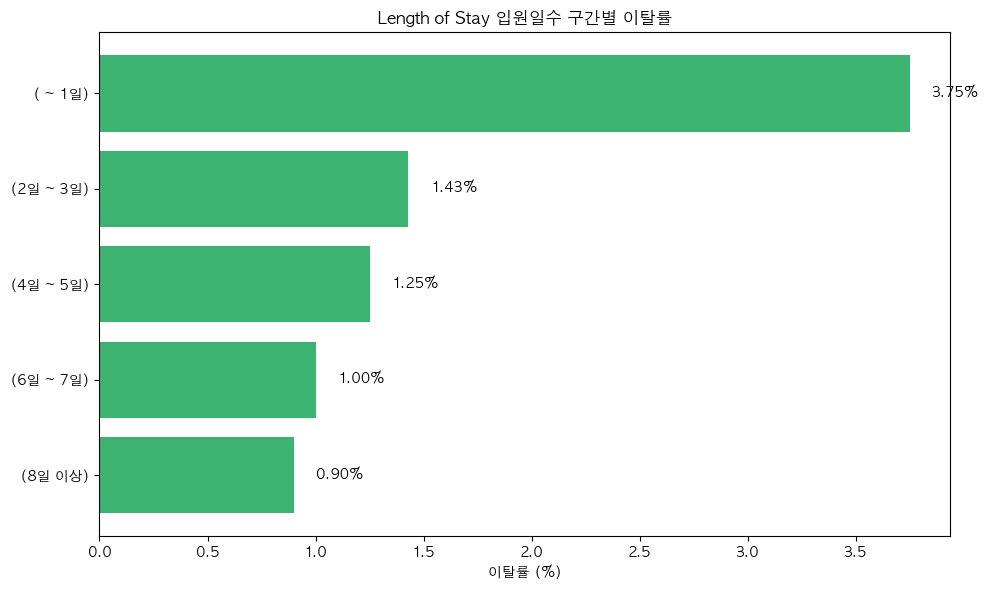

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# macOS 한글 폰트 설정
mpl.rc('font', family='AppleGothic')  # macOS에서 한글 폰트
plt.rcParams['axes.unicode_minus'] = False

# 이탈률 데이터
evasion_rate_stay = pd.Series({
    '( ~ 1일)': 3.75,
    '(2일 ~ 3일)': 1.43,
    '(4일 ~ 5일)': 1.25,
    '(6일 ~ 7일)': 1.00,
    '(8일 이상)': 0.9
})

# 정렬
evasion_rate_stay = evasion_rate_stay.sort_values(ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.barh(evasion_rate_stay.index, evasion_rate_stay.values, color='mediumseagreen')
plt.xlabel('이탈률 (%)')
plt.title('Length of Stay 입원일수 구간별 이탈률')
plt.gca().invert_yaxis()

# 값 표시
for bar in bars:
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}%', va='center')

plt.tight_layout()
plt.show()


1. 입원 첫 1일 이내 환자 이탈률이 가장 높다 (3.71%)

치료가 시작되기 전, 혹은 응급실 방문 후 간단한 검사만 받은 환자들이 자의로 퇴원하는 경우일 수 있습니다.

불만족, 비용 부담, 대기 시간, 또는 상태 호전 등이 원인일 수 있습니다.

2. 입원일수가 늘어날수록 이탈률은 점진적으로 낮아진다

입원 기간이 길어질수록 환자는 치료 계획에 더 깊이 들어가게 되고, 의사의 권고를 따르는 경향이 높습니다.

특히 7일 이상 입원한 환자의 이탈률은 0.78%로 매우 낮습니다.

3. 운영적 해석

병원 입장에서는 입원 초기에 발생하는 이탈을 방지하는 것이 중요합니다.

입원 첫날 환자 경험(응급실 대기, 설명 부족, 초기 진료 미흡 등)을 개선할 경우 전체 이탈률을 크게 낮출 수 있습니다.



In [11]:
### 선정된 모델 최적화 및 평가 
from utils.get_best_model import get_best_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import (precision_recall_curve, roc_curve,
                    average_precision_score, roc_auc_score,
                    PrecisionRecallDisplay, RocCurveDisplay)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 평가지표 초기화 
results = []

# 이진 분류 문제로 변환 
X = df.drop(columns=['Patient Disposition'])
y = np.where(df['Patient Disposition'].values == 'Left Against Medical Advice', 1, 0)

# 데이터 셋 분할 - 훈련 데이터 10%, 테스트 데이터 2%
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.01, test_size=0.004, random_state=42, stratify=y)


# -------------------------------
## Logistic Regression 모델 최적화
# -------------------------------

from sklearn.linear_model import LogisticRegression

# 파라미터 그리드 설정
params = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga']
}
# 하이퍼 파라미터 튜닝
logistic_model = get_best_model('LogisticRegression', \
                                                LogisticRegression(), params, preprocessor2, X_train, y_train)


# -------------------------------
## PR Curve 및 ROC Curve 시각화
# -------------------------------

# 모델 예측
y_pred_proba_logistic = logistic_model.predict_proba(X_test)[:, 1]

# Precision-Recall Curve
prec_logistic, rec_logistic, thresholds = precision_recall_curve(y_test, y_pred_proba_logistic)
ap_logistic = average_precision_score(y_test, y_pred_proba_logistic)

# ROC Curve
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_pred_proba_logistic)
roc_auc_logistic = roc_auc_score(y_test, y_pred_proba_logistic)

# -------------------------------
## 최적 Threshold 를 이용한 평가지표 계산
# -------------------------------

# Best Threshold 찾기 
f1_scores = [f1_score(y_test, y_pred_proba_logistic >= t, zero_division=0) for t in thresholds]
best_threshold_logistic = thresholds[np.argmax(f1_scores)]
print(f"Best Threshold based on F1 Score: {best_threshold_logistic:.2f}")

# 최적 threshold를 사용해 예측값 생성
y_pred_logistic = (y_pred_proba_logistic >= best_threshold_logistic).astype(int)

# 평가지표 계산
logistic_scores = {
    'Accuracy': accuracy_score(y_test, y_pred_logistic),
    'Precision': precision_score(y_test, y_pred_logistic, zero_division=0),
    'Recall': recall_score(y_test, y_pred_logistic, zero_division=0),
    'F1 Score': f1_score(y_test, y_pred_logistic, zero_division=0)
}

# 평가지표 저장
results.append({'Model' : 'LogisticRegression', **logistic_scores})



Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/jangjinseul/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jangjinseul/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jangjinseul/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jangjinseul/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jangjinseul/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification

best parameter: {'model__solver': 'liblinear', 'model__penalty': 'l2', 'model__C': 1}
best score: 0.4468097919634711
Best Threshold based on F1 Score: 0.48


In [13]:
# 특성 이름 추출 (OneHot 인코딩된 feature 이름 포함)
feature_names = logistic_model.named_steps['preprocessor'].transformers_[0][1]\
                    .named_steps['onehotencoder'].get_feature_names_out(cate_columns)
num_features = num_columns
all_features = np.concatenate([feature_names, num_features])

# 계수 가져오기
coef = logistic_model.named_steps['model'].coef_.flatten()

# DataFrame으로 정리
FI_lg = pd.DataFrame({'Feature': all_features, 'Coefficient': coef})
FI_lg = FI_lg.sort_values(by='Coefficient', key=np.abs, ascending=False)

# 상위 n개 출력
print(FI_lg.head(10))


                                                Feature  Coefficient
1201  APR DRG Description_DRUG & ALCOHOL ABUSE OR DE...     3.626107
1139                                   APR DRG Code_770     3.626107
415                                   Age Group_0 to 17    -1.862985
1403          APR Medical Surgical Description_Surgical    -1.720872
435                                 Discharge Year_2010    -1.315899
1141                                   APR DRG Code_773    -1.206672
1266      APR DRG Description_OPIOID ABUSE & DEPENDENCE    -1.206672
419                               Age Group_70 or Older    -1.192925
1143                                   APR DRG Code_775    -1.072811
1163     APR DRG Description_ALCOHOL ABUSE & DEPENDENCE    -1.072811


In [ ]:
# 상위 10개 피처
top_10 = FI_lg.head(10)

# all_features 배열에서 인덱스 찾기
top_10['Index_in_all_features'] = top_10['Feature'].apply(lambda f: np.where(all_features == f)[0][0])

# 인덱스 + 값 출력
for _, row in top_10.iterrows():
    print(f"Feature: {row['Feature']}\n→ Index: {row['Index_in_all_features']}, Coefficient: {row['Coefficient']:.4f}\n")


Feature: APR DRG Description_DRUG & ALCOHOL ABUSE OR DEPENDENCE, LEFT AGAINST MEDICAL ADVICE
→ Index: 1201, Coefficient: 3.6261

Feature: APR DRG Code_770
→ Index: 1139, Coefficient: 3.6261

Feature: Age Group_0 to 17
→ Index: 415, Coefficient: -1.8630

Feature: APR Medical Surgical Description_Surgical
→ Index: 1403, Coefficient: -1.7209

Feature: Discharge Year_2010
→ Index: 435, Coefficient: -1.3159

Feature: APR DRG Code_773
→ Index: 1141, Coefficient: -1.2067

Feature: APR DRG Description_OPIOID ABUSE & DEPENDENCE
→ Index: 1266, Coefficient: -1.2067

Feature: Age Group_70 or Older
→ Index: 419, Coefficient: -1.1929

Feature: APR DRG Code_775
→ Index: 1143, Coefficient: -1.0728

Feature: APR DRG Description_ALCOHOL ABUSE & DEPENDENCE
→ Index: 1163, Coefficient: -1.0728



/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_80169/2744038399.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10['Index_in_all_features'] = top_10['Feature'].apply(lambda f: np.where(all_features == f)[0][0])


In [11]:
# -------------------------------
## Random Forest 모델 최적화
# -------------------------------

from sklearn.ensemble import RandomForestClassifier
# 파라미터 그리드 설정
params = {
    'model__n_estimators': [10, 50, 100, 200],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
# 하이퍼 파라미터 튜닝
rfc_model = get_best_model('RandomForestClassifier', \
                                                RandomForestClassifier(), params, preprocessor, X_train, y_train)


# -------------------------------
## PR Curve 및 ROC Curve 시각화
# -------------------------------

# 모델 예측
y_pred_proba_rfc = rfc_model.predict_proba(X_test)[:, 1]

# Precision-Recall Curve
prec_rfc, rec_rfc, thresholds = precision_recall_curve(y_test, y_pred_proba_rfc)
ap_rfc = average_precision_score(y_test, y_pred_proba_rfc)

# ROC Curve
fpr_rfc, tpr_rfc, _ = roc_curve(y_test, y_pred_proba_rfc)
roc_auc_rfc = roc_auc_score(y_test, y_pred_proba_rfc)

# -------------------------------
## 최적 Threshold 를 이용한 평가지표 계산
# -------------------------------

# Best Threshold 찾기 
f1_scores = [f1_score(y_test, y_pred_proba_rfc >= t, zero_division=0) for t in thresholds]
best_threshold_rfc = thresholds[np.argmax(f1_scores)]
print(f"Best Threshold based on F1 Score: {best_threshold_rfc:.2f}")

# 최적 threshold를 사용해 예측값 생성
y_pred_rfc = (y_pred_proba_rfc >= best_threshold_rfc).astype(int)

# 평가지표 계산
rfc_scores = {
    'Accuracy': accuracy_score(y_test, y_pred_rfc),
    'Precision': precision_score(y_test, y_pred_rfc, zero_division=0),
    'Recall': recall_score(y_test, y_pred_rfc, zero_division=0),
    'F1 Score': f1_score(y_test, y_pred_rfc, zero_division=0)
}

# 평가지표 저장
results.append({'Model' : 'RandomForestClassifier', **rfc_scores})


Fitting 3 folds for each of 10 candidates, totalling 30 fits
best parameter: {'model__n_estimators': 50, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_depth': None}
best score: 0.43798274395782716
Best Threshold based on F1 Score: 0.28


In [19]:
# 1. 전처리된 feature 이름들 추출 (범주형 OneHot 인코딩 포함)
feature_names = rfc_model.named_steps['preprocessor'].transformers_[0][1]\
                    .named_steps['ordinalencoder'].get_feature_names_out(cate_columns)
num_features = num_columns
all_features = np.concatenate([feature_names, num_features])

# 2. 특성 중요도 가져오기
importances = rfc_model.named_steps['model'].feature_importances_

# 3. DataFrame으로 정리 및 정렬
FI_rf = pd.DataFrame({'Feature': all_features, 'Importance': importances})
FI_rf = FI_rf.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# 4. 상위 10개 인덱스 및 값 확인
FI_rf['Index_in_all_features'] = FI_rf['Feature'].apply(lambda f: np.where(all_features == f)[0][0])
print(FI_rf.head(10))


                     Feature  Importance  Index_in_all_features
0               APR DRG Code    0.186951                     14
1        APR DRG Description    0.139447                     15
2                Total Costs    0.070296                     26
3              Total Charges    0.069427                     25
4        APR MDC Description    0.062252                     17
5         CCS Diagnosis Code    0.046232                     10
6  CCS Procedure Description    0.046027                     13
7             Length of Stay    0.044471                     27
8                Facility ID    0.042853                      2
9              Facility Name    0.042374                      3


In [20]:
# -------------------------------
## XGBoost 모델 최적화
# -------------------------------

from xgboost import XGBClassifier
# 파라미터 그리드 설정
params = {
    'model__n_estimators': [10, 50, 100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.5, 0.7, 1.0],
    'model__colsample_bytree': [0.5, 0.7, 1.0]
}
# 하이퍼 파라미터 튜닝
xgb_model = get_best_model('XGBClassifier',\
                                                XGBClassifier(), params, preprocessor, X_train, y_train)


# -------------------------------
## PR Curve 및 ROC Curve 시각화
# -------------------------------

# 모델 예측
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Precision-Recall Curve
prec_xgb, rec_xgb, thresholds = precision_recall_curve(y_test, y_pred_proba_xgb)
ap_xgb = average_precision_score(y_test, y_pred_proba_xgb)

# ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

# -------------------------------
## 최적 Threshold 를 이용한 평가지표 계산
# -------------------------------

# Best Threshold 찾기 
f1_scores = [f1_score(y_test, y_pred_proba_xgb >= t, zero_division=0) for t in thresholds]
best_threshold_xgb = thresholds[np.argmax(f1_scores)]
print(f"Best Threshold based on F1 Score: {best_threshold_xgb:.2f}")

# 최적 threshold를 사용해 예측값 생성
y_pred_xgb = (y_pred_proba_xgb >= best_threshold_xgb).astype(int)

# 평가지표 계산
xgb_scores = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb, zero_division=0),
    'Recall': recall_score(y_test, y_pred_xgb, zero_division=0),
    'F1 Score': f1_score(y_test, y_pred_xgb, zero_division=0)
}

# 평가지표 저장
results.append({'Model' : 'XGBClassifier', **xgb_scores})


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/jangjinseul/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jangjinseul/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jangjinseul/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jangjinse

best parameter: {'model__subsample': 0.7, 'model__n_estimators': 200, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.5}
best score: 0.45512908673768154
Best Threshold based on F1 Score: 0.57


Feature name count: 28, Importance count: 28


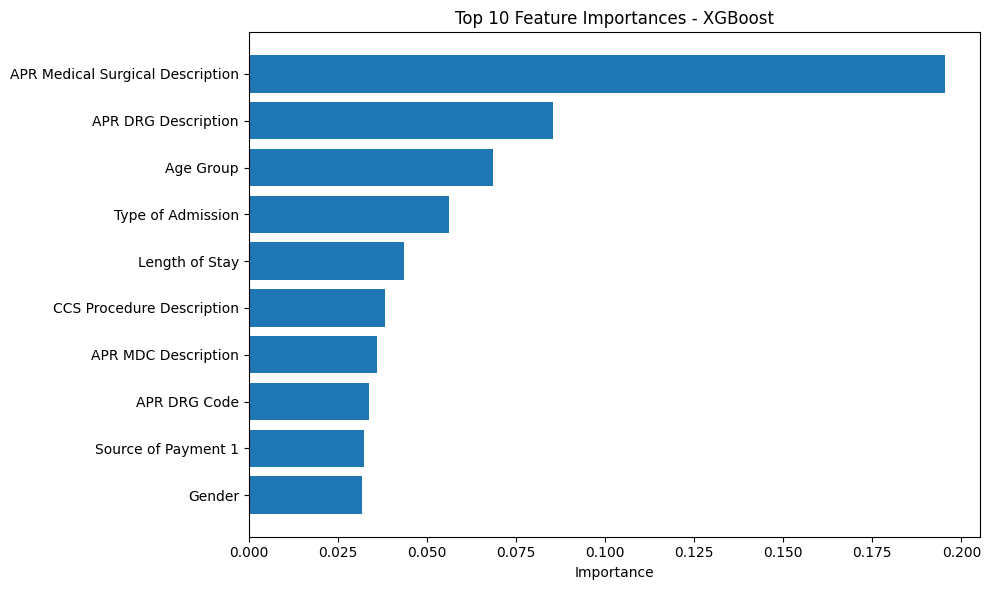

                             Feature  Importance
21  APR Medical Surgical Description    0.195329
15               APR DRG Description    0.085294
4                          Age Group    0.068558
8                  Type of Admission    0.056307
27                    Length of Stay    0.043607
13         CCS Procedure Description    0.038158
17               APR MDC Description    0.035863
14                      APR DRG Code    0.033866
22               Source of Payment 1    0.032436
5                             Gender    0.031770


In [23]:
# 전체 feature 이름 추출 (OrdinalEncoded + 수치형)
cat_features = xgb_model.named_steps['preprocessor'].transformers_[0][1]\
    .named_steps['ordinalencoder'].get_feature_names_out(cate_columns)
all_features = np.concatenate([cat_features, num_columns])

# 중요도 추출
importances = xgb_model.named_steps['model'].feature_importances_

# 길이 확인 (디버깅용)
print(f"Feature name count: {len(all_features)}, Importance count: {len(importances)}")

# DataFrame 생성
FI_xgb = pd.DataFrame({'Feature': all_features, 'Importance': importances})
FI_xgb = FI_xgb.sort_values(by='Importance', ascending=False).head(10)

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(FI_xgb['Feature'], FI_xgb['Importance'])
plt.gca().invert_yaxis()
plt.title('Top 10 Feature Importances - XGBoost')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# 결과 확인
print(FI_xgb)


In [26]:
# -------------------------------
## GradientBoosting 모델 최적화
# -------------------------------

from sklearn.ensemble import GradientBoostingClassifier
# 파라미터 그리드 설정
params = {
    'model__n_estimators': [10, 50, 100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.5, 0.7, 1.0],
    'model__min_samples_split': [2, 5, 10]
}
# 하이퍼 파라미터 튜닝
gb_model = get_best_model('GradientBoosting',\
                                                GradientBoostingClassifier(), params, preprocessor, X_train, y_train)


# -------------------------------
## PR Curve 및 ROC Curve 시각화
# -------------------------------

# 모델 예측
y_pred_proba_gb = gb_model.predict_proba(X_test)[:, 1]

# Precision-Recall Curve
prec_gb, rec_gb, thresholds = precision_recall_curve(y_test, y_pred_proba_gb)
ap_gb = average_precision_score(y_test, y_pred_proba_gb)

# ROC Curve
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba_gb)
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)

# -------------------------------
## 최적 Threshold 를 이용한 평가지표 계산
# -------------------------------

# Best Threshold 찾기 
f1_scores = [f1_score(y_test, y_pred_proba_gb >= t, zero_division=0) for t in thresholds]
best_threshold_gb = thresholds[np.argmax(f1_scores)]
print(f"Best Threshold based on F1 Score: {best_threshold_gb:.2f}")

# 최적 threshold를 사용해 예측값 생성
y_pred_gb = (y_pred_proba_gb >= best_threshold_gb).astype(int)

# 평가지표 계산
gb_scores = {
    'Accuracy': accuracy_score(y_test, y_pred_gb),
    'Precision': precision_score(y_test, y_pred_gb, zero_division=0),
    'Recall': recall_score(y_test, y_pred_gb, zero_division=0),
    'F1 Score': f1_score(y_test, y_pred_gb, zero_division=0)
}

# 평가지표 저장
results.append({'Model' : 'GradientBoosting', **gb_scores})


Fitting 3 folds for each of 10 candidates, totalling 30 fits
best parameter: {'model__subsample': 0.7, 'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__max_depth': 3, 'model__learning_rate': 0.1}
best score: 0.4554812250960764
Best Threshold based on F1 Score: 0.72


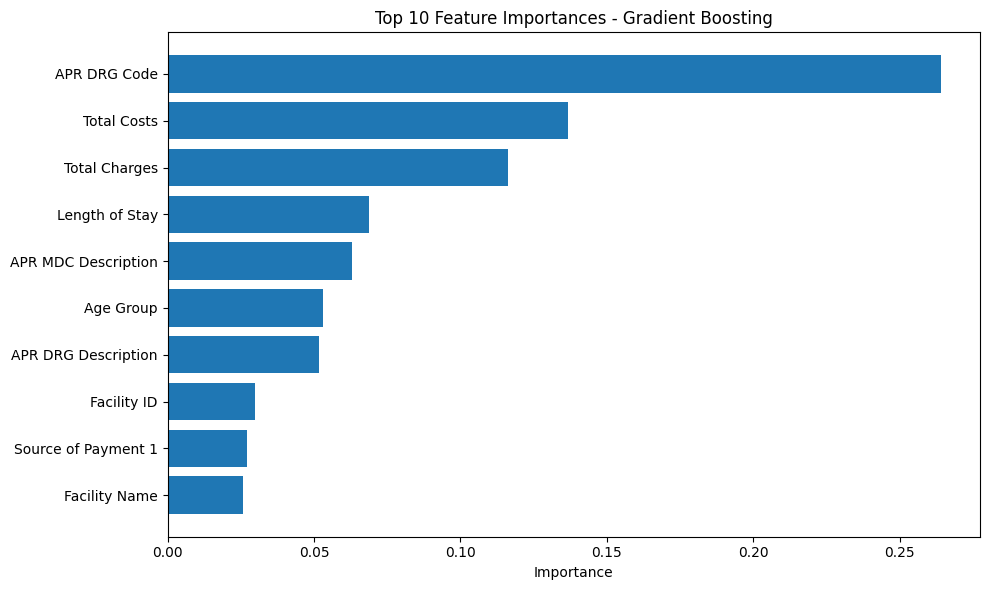

                Feature  Importance
14         APR DRG Code    0.264175
26          Total Costs    0.136781
25        Total Charges    0.116248
27       Length of Stay    0.068644
17  APR MDC Description    0.062834
4             Age Group    0.053216
15  APR DRG Description    0.051537
2           Facility ID    0.029698
22  Source of Payment 1    0.027278
3         Facility Name    0.025855


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. 전처리된 feature 이름 추출
cat_features = gb_model.named_steps['preprocessor'].transformers_[0][1]\
    .named_steps['ordinalencoder'].get_feature_names_out(cate_columns)
all_features = np.concatenate([cat_features, num_columns])

# 2. feature importance 추출
importances = gb_model.named_steps['model'].feature_importances_

# 3. DataFrame으로 정리 후 상위 10개 추출
FI_gb = pd.DataFrame({'Feature': all_features, 'Importance': importances})
FI_gb = FI_gb.sort_values(by='Importance', ascending=False).head(10)

# 4. 시각화
plt.figure(figsize=(10, 6))
plt.barh(FI_gb['Feature'], FI_gb['Importance'])
plt.gca().invert_yaxis()
plt.title('Top 10 Feature Importances - Gradient Boosting')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# 결과 출력
print(FI_gb)


In [28]:
# APR DRG Code 컬럼에서 상위 10개의 고유값과 그 개수를 출력
top_10_apr_drg = df['APR DRG Code'].value_counts().head(10)
print(top_10_apr_drg)


APR DRG Code
640       210859
560       152307
Others    133723
540        81315
194        55247
139        50257
140        47464
720        46841
383        41739
203        39696
Name: count, dtype: int64


In [39]:
# 상위 10개의 APR DRG Code + Description 조합 집계
top_10_apr_drg_df = df.groupby(['APR DRG Code', 'APR DRG Description']) \
                      .size() \
                      .sort_values(ascending=False) \
                      .head(10) \
                      .reset_index(name='Count')

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(
    top_10_apr_drg_df['APR DRG Code'].astype(str) + " - " + top_10_apr_drg_df['APR DRG Description'],
    top_10_apr_drg_df['Count']
)
plt.gca().invert_yaxis()
plt.xlabel("Count")
plt.title("Top 10 APR DRG Codes by Frequency")
plt.tight_layout()
plt.show()


KeyError: 'APR DRG Code'

In [31]:
# df에 'y' 컬럼이 있다고 가정 (이탈 여부: 1 또는 0)
df['y'] = np.where(df['Patient Disposition'] == 'Left Against Medical Advice', 1, 0)

# 각 DRG 코드별 이탈률 계산
drg_evasion = df.groupby('APR DRG Code')['y'].mean().sort_values(ascending=False)
print(drg_evasion.head(10))


APR DRG Code
770    1.000000
894    0.139463
816    0.134312
892    0.117631
662    0.107234
890    0.085417
280    0.063636
282    0.061515
566    0.060130
251    0.059200
Name: y, dtype: float64


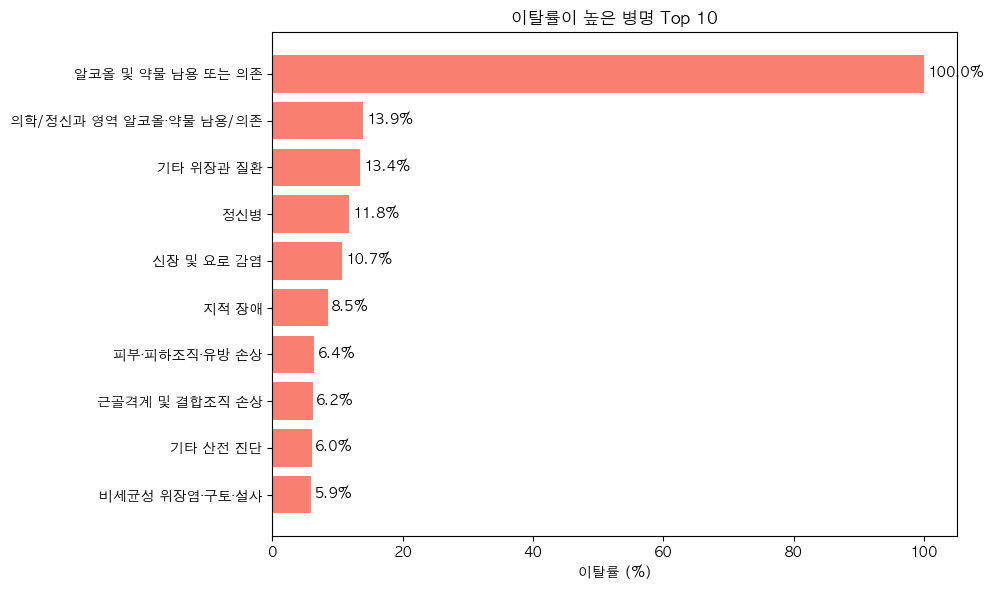

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# ✅ Mac에서 한글 폰트 설정 (예: AppleGothic)
if platform.system() == 'Darwin':  # Mac OS
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows':  # 윈도우일 경우 예시
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:  # 리눅스 등
    plt.rcParams['font.family'] = 'NanumGothic'

# ✅ 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 데이터 준비
data = {
    '병명 코드': [770, 894, 816, 892, 662, 890, 280, 282, 566, 251],
    '병명 (한글 번역)': [
        '알코올 및 약물 남용 또는 의존',
        '의학/정신과 영역 알코올·약물 남용/의존',
        '기타 위장관 질환',
        '정신병',
        '신장 및 요로 감염',
        '지적 장애',
        '피부·피하조직·유방 손상',
        '근골격계 및 결합조직 손상',
        '기타 산전 진단',
        '비세균성 위장염·구토·설사'
    ],
    '이탈률': [100.0, 13.9, 13.4, 11.8, 10.7, 8.5, 6.4, 6.2, 6.0, 5.9]
}

df = pd.DataFrame(data)

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.barh(df['병명 (한글 번역)'], df['이탈률'], color='salmon')
plt.xlabel('이탈률 (%)')
plt.title('이탈률이 높은 병명 Top 10')
plt.gca().invert_yaxis()

# 각 막대에 수치 표시
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.1f}%', va='center')

plt.tight_layout()
plt.show()


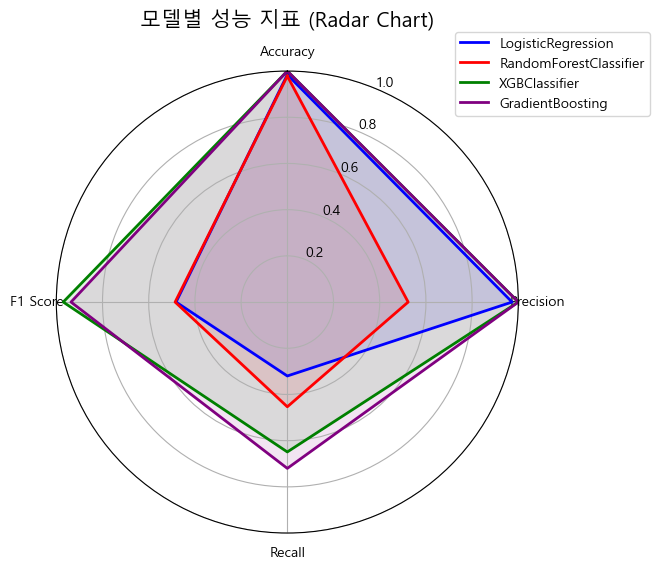

In [ ]:
### 모델별 결과 시각화 - 평가지표(Radar Chart)
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import seaborn as sns
import os

img_dir = 'images'
os.makedirs(img_dir, exist_ok=True)

# 한글 폰트 설정 (Windows 기준)
mpl.rc('font', family='Malgun Gothic')

# 마이너스 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

# 모델별 성능 비교 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)
results_df = results_df.set_index('Model')

# 레이더차트 설정
labels = results_df.columns.tolist()
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # 첫 포인트로 되돌아가기

# 차트 초기화
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
plt.title("모델별 성능 지표 (Radar Chart)", size=15, y=1.08)

# 각 모델별로 plot
colors = ['blue', 'red', 'green', 'purple']
for i, (model_name, row) in enumerate(results_df.iterrows()):
    values = row.tolist()  
    if i in [2, 3]:
        values = [min(1, v * 2) for v in values]
    
    values += values[:1]
    ax.plot(angles, values, label=model_name, color=colors[i], linewidth=2)
    ax.fill(angles, values, color=colors[i], alpha=0.1)

# 축 레이블 설정
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)

# 반지름 값 고정
ax.set_ylim(0, 1)

# 범례
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.savefig(os.path.join(img_dir, 'radar_chart.png'), dpi=300, bbox_inches='tight')
plt.show()

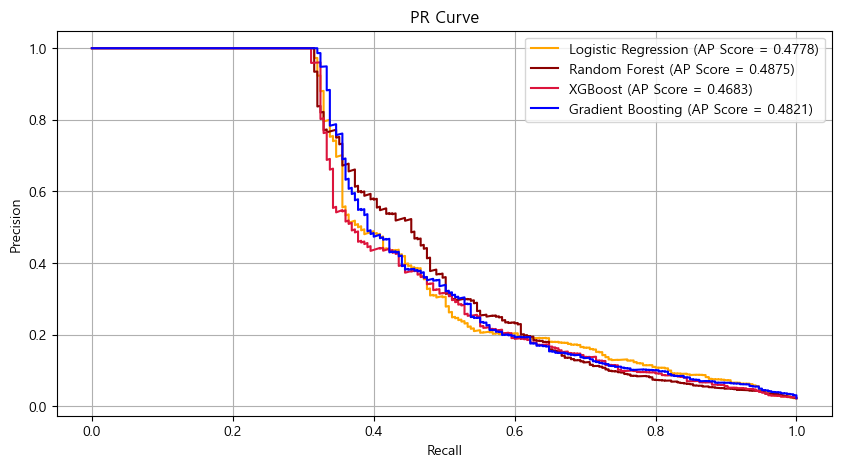

In [ ]:
### 모델별 결과 시각화 - PR Curve

plt.figure(figsize=(10, 5))
plt.plot(rec_logistic, prec_logistic, label=f'Logistic Regression (AP Score = {ap_logistic:.4f})', color='orange')
plt.plot(rec_rfc, prec_rfc, label=f'Random Forest (AP Score = {ap_rfc:.4f})', color='darkred')
plt.plot(rec_xgb, prec_xgb, label=f'XGBoost (AP Score = {ap_xgb:.4f})', color='crimson')
plt.plot(rec_gb, prec_gb, label=f'Gradient Boosting (AP Score = {ap_gb:.4f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(img_dir, 'PR_Curve.png'), dpi=300, bbox_inches='tight')
plt.show()


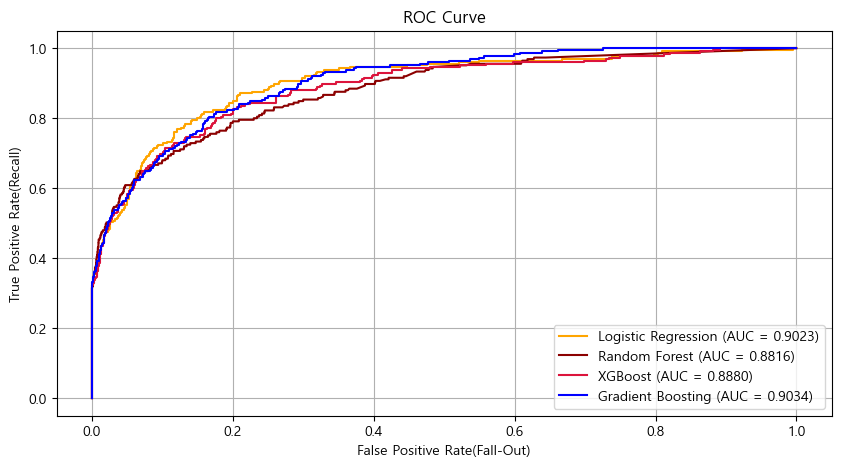

In [ ]:
### 모델별 결과 시각화 - ROC Curve

plt.figure(figsize=(10, 5))
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (AUC = {roc_auc_logistic:.4f})', color='orange')
plt.plot(fpr_rfc, tpr_rfc, label=f'Random Forest (AUC = {roc_auc_rfc:.4f})', color='darkred')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})', color='crimson')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.4f})', color='blue')
plt.xlabel('False Positive Rate(Fall-Out)')
plt.ylabel('True Positive Rate(Recall)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(img_dir, 'ROC_Curve.png'), dpi=300, bbox_inches='tight')
plt.show()


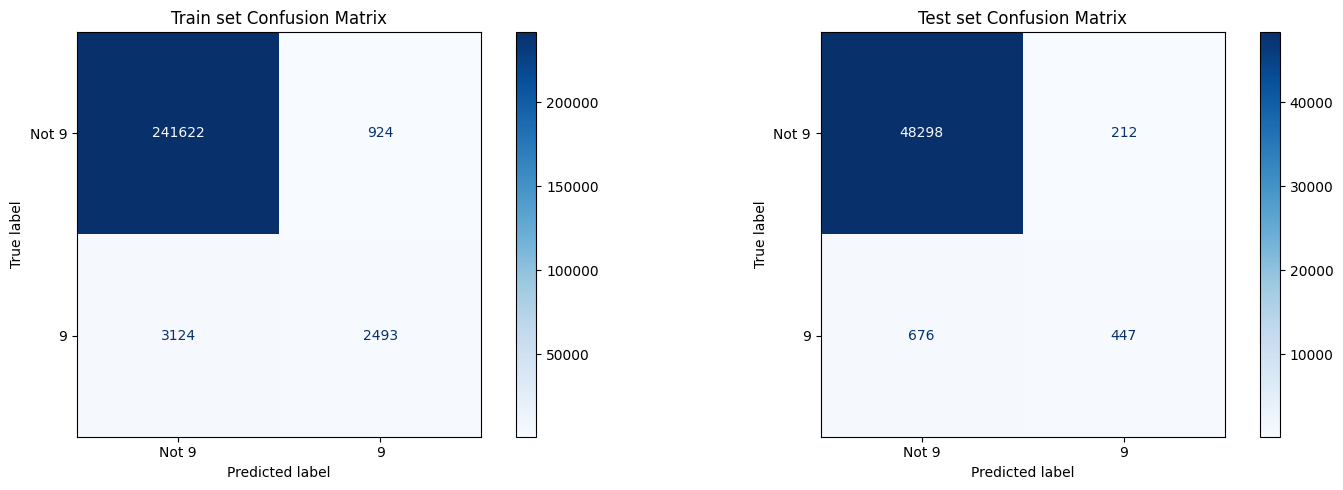

In [ ]:
### 모델별 결과 시각화 - 혼동행렬 - 최종 모델(xgboost)만
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 모델 예측
y_pred_proba_train = xgb_model.predict_proba(X_train)[:, 1]
y_pred_proba_test = xgb_model.predict_proba(X_test)[:, 1]
y_pred_train = (y_pred_proba_train >= best_threshold_xgb).astype(int)
y_pred_test = (y_pred_proba_test >= best_threshold_xgb).astype(int)

# 혼동행렬 생성
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

# 혼동행렬 시각화
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

disp_train = ConfusionMatrixDisplay(
    cm_train, #confusion matrix
    display_labels=['Not 9', '9']       # [음성레이블, 양성레이블]
)
disp_train.plot(cmap='Blues', ax=ax1)    # 출력

disp_test = ConfusionMatrixDisplay(
    cm_test, #confusion matrix
    display_labels=['Not 9', '9']) 

disp_test.plot(cmap='Blues', ax=ax2)

ax1.set_title("Train set Confusion Matrix")
ax2.set_title("Test set Confusion Matrix")
plt.tight_layout()
plt.savefig('Confusion_Matrix.png', dpi=300, bbox_inches='tight')
plt.show()
